# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# Описание данных

Данные геологоразведки трёх регионов находятся в файлах: 

•	/datasets/geo_data_0.csv. 

•	/datasets/geo_data_1.csv.

•	/datasets/geo_data_2.csv.

•	id — уникальный идентификатор скважины;

•	f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);

•	product — объём запасов в скважине (тыс. баррелей).

Условия задачи:

•	Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

•	При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

•	Бюджет на разработку скважин в регионе — 10 млрд рублей.

•	При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

•	После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.


## Загрузка и подготовка данных

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats as st

In [27]:
def read_data(file_name):
    try:
        if basename(normpath(getcwd())) == 'praktikum_new':
            df_ = pd.read_csv(f".\datasets\\{file_name}")#local
        else:
            df_ = pd.read_csv(f"/datasets/{file_name}")#server
    except:
        df_ = pd.read_csv(f"/datasets/{file_name}")#server
    return df_

geo_0 = read_data('geo_data_0.csv')
geo_1 = read_data('geo_data_1.csv')
geo_2 = read_data('geo_data_2.csv')

Пример содержимого таблиц:

In [28]:
geo_0.sample(2, random_state=12345)

,id,f0,f1,f2,product
71751,7Z2gx,0.948970,-0.057547,2.095727,10.038645
80493,b2HU8,0.992974,0.206671,-0.142278,114.551489


In [29]:
geo_1.sample(2, random_state=12345)

,id,f0,f1,f2,product
71751,aTbUt,-0.371866,-1.862494,3.002210,80.859783
80493,CK34V,9.015122,-13.881455,1.995363,53.906522


In [30]:
geo_2.sample(2, random_state=12345)

,id,f0,f1,f2,product
71751,DMlgl,-1.444717,-3.861599,2.225805,61.212375
80493,tbrRC,-1.418617,1.276544,-0.976433,41.850118


Информация о датасетах:

In [31]:
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [32]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [33]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


ВЫВОД: значения в датасетах корректны.

# Проверяю на наличие  дубликатов:

In [34]:
geo_0.duplicated().sum()

0

In [35]:
geo_1.duplicated().sum()

0

In [36]:
geo_2.duplicated().sum()

0

ВЫВОД: полных дубликатов нет.

# Удаление лишних признаков

Удаляю  колонку id, т.к. данные в ней будут мешать обучению моделей и  знать названия скважин нет необходимости.

In [37]:
geo_0 = geo_0.drop(['id'], axis=1)
geo_0.columns

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

In [38]:
geo_1 = geo_1.drop(['id'], axis=1)
geo_1.columns

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

In [39]:
geo_2 = geo_2.drop(['id'], axis=1)
geo_2.columns

Index(['f0', 'f1', 'f2', 'product'], dtype='object')

ВЫВОД: колонка с признаком  id удалена из всех регионов.

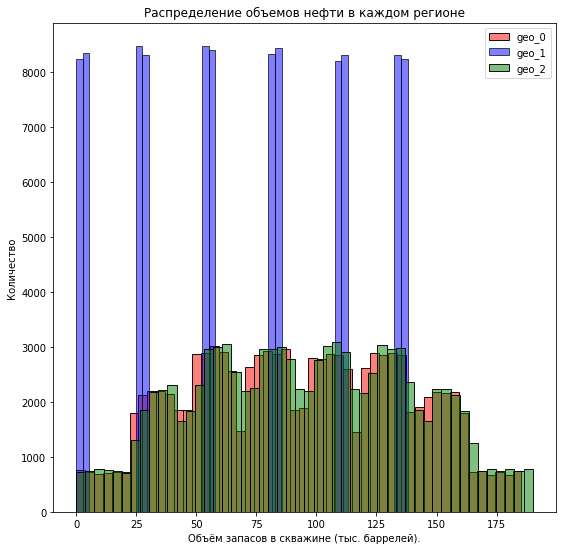

In [40]:
fig, ax = plt.subplots(figsize=(9,9))
sns.histplot(data=geo_0['product'], ax=ax, bins=50, color='red', alpha = 0.5, label='geo_0')
sns.histplot(data=geo_1['product'], ax=ax, bins=50, color='blue', alpha = 0.5, label='geo_1')
sns.histplot(data=geo_2['product'], ax=ax, bins=50, color='green', alpha = 0.5, label='geo_2')
ax.set_xlabel('Объём запасов в скважине (тыс. баррелей).')
ax.set_ylabel('Количество')
ax.set_title('Распределение объемов нефти в каждом регионе')
plt.legend()
plt.show()

ВЫВОД:  объем нефти в скважинах  первого региона (geo_1) сильно превышает объем нефти в скважинах 
        в двух других регионах(geo_0 и geo_2).

ВЫВОД: Пропуски и дубликаты в данных отсутствуют;

       Все признаки имеют числовое представление;
       
       Столбцы с признаком id удалены из всех регионов;
       
       Объем запасов нефти распределен между регионами неравномерно;
       
       Данные подготовил в исследованию.

## Обучение и проверка модели

Для начала нужно разделить исходные данные на 2 выборки: обучающую и тестовую в соотношении 
75 и 25%. 
Затем обучить модель линейной регрессии на обучающей выборке и выполнить предсказания на валидационных данных по очереди для каждого региона.

функция create_sample() по словарю, содержащим датафрейм, будет готовить следующие выборки features_train, features_valid, target_train, target_valid

In [41]:
def create_sample(dict_):
    df = list(dict_.values())[0]
    name = list(dict_.keys())[0]
    features = df.drop('product', axis=1)# извлеките признаки 
    target = df['product']# извлеките целевой признак
    
    # разбиваем выборки на обучающую и валидационную
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target,
                                                                                  test_size=0.25,
                                                                                  random_state=12345)
    print(f'Весь датасет региона {name}')
    print('features_train.shape = ', features_train.shape, 'target_train.shape = ', target_train.shape)
    print('features_valid.shape = ', features_valid.shape, 'target_valid.shape = ', target_valid.shape)
    
    
    scaler = StandardScaler()   # масштабируем признаки
    scaler.fit(features_train)

    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    return features_train, features_valid, target_train.reset_index(drop=True), target_valid.reset_index(drop=True)

In [42]:
geo_0_features_train, geo_0_features_valid, geo_0_target_train, geo_0_target_valid = create_sample({'geo_0': geo_0})
geo_1_features_train, geo_1_features_valid, geo_1_target_train, geo_1_target_valid = create_sample({'geo_1': geo_1})
geo_2_features_train, geo_2_features_valid, geo_2_target_train, geo_2_target_valid = create_sample({'geo_2': geo_2})

Весь датасет региона geo_0
features_train.shape =  (75000, 3) target_train.shape =  (75000,)
features_valid.shape =  (25000, 3) target_valid.shape =  (25000,)
Весь датасет региона geo_1
features_train.shape =  (75000, 3) target_train.shape =  (75000,)
features_valid.shape =  (25000, 3) target_valid.shape =  (25000,)
Весь датасет региона geo_2
features_train.shape =  (75000, 3) target_train.shape =  (75000,)
features_valid.shape =  (25000, 3) target_valid.shape =  (25000,)


ВЫВОД: данные  разбиты на обучающую и валидационную выборки в пропорции 75:25

# Обучение и предсказание моделей

функция fit_predict() для обучения  и предсказания модели.
В качестве модели будем использовать LinearRegression() т.к. работаем с предсказанием численного значения. 
На выходе функция будет расчитывать ошибку по метрике RMSE и возращять предсказанные значения на валидационной выборке

In [43]:
def fit_predict(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train,target_train)
    predicted_train = model.predict(features_train)
    predicted_valid = model.predict(features_valid)
    return mean_squared_error(target_train, predicted_train) ** 0.5, \
           mean_squared_error(target_valid, predicted_valid) ** 0.5, predicted_valid

In [44]:
rmse_geo_0_train, rmse_geo_0_valid, predicted_valid_geo_0 = fit_predict(geo_0_features_train, geo_0_features_valid, geo_0_target_train, geo_0_target_valid)
rmse_geo_1_train, rmse_geo_1_valid, predicted_valid_geo_1 = fit_predict(geo_1_features_train, geo_1_features_valid, geo_1_target_train, geo_1_target_valid)
rmse_geo_2_train, rmse_geo_2_valid, predicted_valid_geo_2 = fit_predict(geo_2_features_train, geo_2_features_valid, geo_2_target_train, geo_2_target_valid)

In [45]:
print('Регион GEO_0')
print('RMSE(train):', rmse_geo_0_train, '\nRMSE(valid):', rmse_geo_0_valid, '\nСредний запас предсказанного сырья:', predicted_valid_geo_0.mean())

Регион GEO_0
RMSE(train): 37.72999219904026 
RMSE(valid): 37.5794217150813 
Средний запас предсказанного сырья: 92.59256778438035


In [46]:
print('Регион GEO_1')
print('RMSE(train):', rmse_geo_1_train, '\nRMSE(valid):', rmse_geo_1_valid, '\nСредний запас предсказанного сырья:', predicted_valid_geo_0.mean())

Регион GEO_1
RMSE(train): 0.8894720773917386 
RMSE(valid): 0.893099286775617 
Средний запас предсказанного сырья: 92.59256778438035


In [47]:
print('Регион GEO_2')
print('RMSE(train):', rmse_geo_2_train, '\nRMSE(valid):', rmse_geo_2_valid, '\nСредний запас предсказанного сырья:', predicted_valid_geo_2.mean())

Регион GEO_2
RMSE(train): 40.06425978832384 
RMSE(valid): 40.02970873393434 
Средний запас предсказанного сырья: 94.96504596800489


Тепловые карты данных для каждого региона для проверки корреляции признаков:

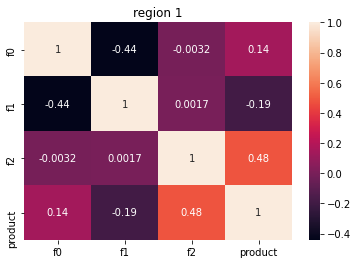

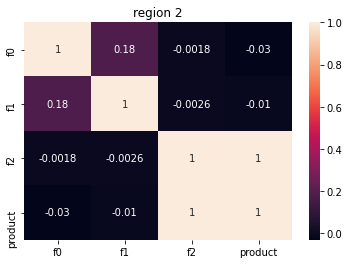

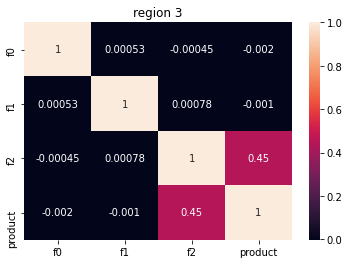

In [48]:
regions = [geo_0, geo_1, geo_2]
for i in range(len(regions)):
    ax = plt.axes()
    sns.heatmap(regions[i].corr(), annot = True)
    ax.set_title('region ' + str(i+1))
    plt.show()

вывод: высокая корреляция между признаком f2 и целевым признаком в регионе №2, поэтому среднеквадратическая ошибка RMSE в этом регионе меньше 1.

ВЫВОД: Модели обучены. Посчитан средний запас предсказанного сырья в каждом регионе.
       Ошибка модели LinearRegression по метрике RMSE не отличается  на обучающей 
       и валидационной выборке.

## Подготовка к расчёту прибыли

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей. 

При нынешних ценах один баррель сырья приносит 450 рублей дохода.

Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

In [49]:
BUDGET_ONE_REGION  = 10e9      #Бюджет 10 млрд рублей
COST_UNIT_PRODUCT = 450e3     #один баррель сырья приносит 450 рублей дохода
COUNT_PROSPECTION_POINT = 500 #При разведке региона исследуют 500 точек
COUNT_BEST_POINT = 200        #200 лучших точек для разработки.

Минимальное среднее количество продукта в месторождениях региона, достаточное для разработки:


In [51]:
#бюджет делим на число возможных разрабатываем точек
min_money_in_well = BUDGET_ONE_REGION/COUNT_BEST_POINT 
#получим минимальный доход со скважины в рублях.
min_money_in_well

50000000.0

In [53]:
#делим бюджет скважины на доход от одной единицы сырья.
min_mean_product_in_well = min_money_in_well/COST_UNIT_PRODUCT
min_mean_product_in_well

111.11111111111111

ВЫВОД:для безубыточной добычи топлива необходимо, чтобы каждая скважина в среднем содержала не менее 111 тысяч баррелей нефти. 

Составим сводную таблицу для регионов и сравним его показатель с минимальным средним количеством продукта:

In [54]:
mean_product_pivot = pd.DataFrame({'mean_product': [predicted_valid_geo_0.mean(), predicted_valid_geo_1.mean(), predicted_valid_geo_2.mean()],
                                   'min_mean_product_in_well': [min_mean_product_in_well]*3})
mean_product_pivot['good_region'] = mean_product_pivot['mean_product'] > mean_product_pivot['min_mean_product_in_well']
mean_product_pivot

,mean_product,min_mean_product_in_well,good_region
0,92.592568,111.111111,False
1,68.728547,111.111111,False
2,94.965046,111.111111,False


ВЫВОД:Рассчитал необходимое количество сырья для безубыточной разработки новой скважины: 111.11 баррелей;

После сравнения средних предсказанных моделью запасов сырья, выяснил, что среднее значение запасов во всех трех регионах меньше необходимого количества для безубыточной разработки;

Нужно провести селекцию скважин и отобрать лучшие.

## Расчёт прибыли и рисков 

Функция для расчёта прибыли:

In [67]:
#def revenue(target_valid_subsample,predicted_valid_subsample ):
#    select_predicted_wells_best = predicted_valid_subsample.sort_values(ascending=False)[:count_best_point]
 #   target_best = target_valid_subsample[select_predicted_wells_best.index]
  #  return target_best.sum() * cost_unit_product - budget_one_region

def revenue(target_valid_subsample, predicted_valid_subsample):
    target_valid_subsample = pd.Series(target_valid_subsample).reset_index(drop=True)
    predicted_valid_subsample = pd.Series(predicted_valid_subsample).reset_index(drop=True)
    select_predicted_wells_best = predicted_valid_subsample.sort_values(ascending=False)[:COUNT_BEST_POINT].index
    target_best = target_valid_subsample[select_predicted_wells_best]
    return target_best.sum() * COST_UNIT_PRODUCT - BUDGET_ONE_REGION
    

Функция bootstrap_method_calc_income_in_region() расчитывает распределение прибыли техникой Bootstrap.

In [68]:
def bootstrap_method(target_valid_, predicted_valid_):
    bootstrap = []
    # защита от random_state случайный элемент всегда одинаковый
    state=np.random.RandomState(2007)
    for _ in range(1000):
        # при значении параметра replace=True в выборку тоже попадут пять строк, но некоторые — несколько раз
        target_valid_subsample = pd.Series(target_valid_).sample(n=COUNT_PROSPECTION_POINT, random_state=state, replace=True)
        predicted_valid_subsample = pd.Series(predicted_valid_)[target_valid_subsample.index]
        bootstrap.append(revenue(target_valid_subsample, predicted_valid_subsample))
    return pd.Series(bootstrap)

Функция calc_confidence_interval() расчитывает доверительный интрервал по заданному распределению и среднюю прибыль.

In [69]:
def calc_confidence_interval(interval, massive):
    left_interval = (1 - interval)/2
    right_interval = interval + (1 - interval)/2
    mean = massive.mean()
    lower = massive.quantile(left_interval)
    hight = massive.quantile(right_interval)
    risk = (massive < 0).mean()
    print(f'{left_interval:.2%}-квантиль: {lower:.0f} руб. < mean: {mean:.0f} руб. < {right_interval:.2%}-квантиль: {hight:.0f} руб.')
    print('Риск убытков:', round(risk*100, 2), '%')
    return mean, lower, hight, risk


Расчет для регионов:

регион geo_0:

In [70]:
geo_0_revenue = bootstrap_method(geo_0_target_valid, predicted_valid_geo_0)
calc_confidence_interval(.95, geo_0_revenue)
pass

2.50%-квантиль: -78518089 руб. < mean: 378259145 руб. < 97.50%-квантиль: 867084544 руб.
Риск убытков: 6.7 %


регион geo_1:

In [71]:
geo_1_revenue = bootstrap_method(geo_1_target_valid, predicted_valid_geo_1)
calc_confidence_interval(.95, geo_1_revenue)
pass

2.50%-квантиль: 31668395 руб. < mean: 455007924 руб. < 97.50%-квантиль: 861592994 руб.
Риск убытков: 1.4 %


регион geo_2:

In [72]:
geo_2_revenue = bootstrap_method(geo_2_target_valid, predicted_valid_geo_2)
calc_confidence_interval(.95, geo_2_revenue)
pass

2.50%-квантиль: -168276215 руб. < mean: 370258479 руб. < 97.50%-квантиль: 859802562 руб.
Риск убытков: 8.8 %


# Визуализация распределений прибыли в регионах

In [73]:
#функция для построения совмещенного графика диаграммы распредления и гистограммы прибыли в регионе

def histogram_boxplot(axes, data, xrange, xlabel=None, title=None, bins=10):
    # построить диаграмму распределения
    sns.boxplot(x=data, ax=axes[0])
    # построить гистрограмму (с и без bins)
    sns.histplot(x=data, ax=axes[1], bins=bins, kde=True) if bins else sns.histplot(data, ax=axes[1], kde=True)
  
    if xlabel: axes[1].set(xlabel=xlabel)
    if title: axes[0].set(title=title)
    
    axes[1].set_xlim(xrange[0:2])
    axes[1].xaxis.set(ticks=np.arange(*xrange))
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

In [74]:
def multi_subplot(data, xrange, xlabel=None, title=None, font_scale=1.5, figsize=(9,9), space=(0.2, 0.3), bins=10):
    sns.set(font_scale=font_scale)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    
    fig = plt.figure(figsize=figsize)
    outer = gridspec.GridSpec(2, 2, wspace=space[0], hspace=space[1])
    
    # каждый график отдельно
    for i, vec  in enumerate(data):
        # формирование subplots для двух вложенных графиков (box и hist)
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                        subplot_spec=outer[i], wspace=0.1, hspace=0.0, height_ratios=(.05, .95))
        
        ax_box = plt.Subplot(fig, inner[0])
        ax_hist = plt.Subplot(fig, inner[1])
        
        # проверка на существование заголовков на входе функции
        if title:
            title_i = title[i]
        else:
            title_i = None
         # проверка на существование подписи на входе функции    
        if xlabel:
            xlabel_i = xlabel[i]
        else:
            xlabel_i = None
        
        sns.set_style("darkgrid", {"axes.facecolor": ".9"})
        
        histogram_boxplot((ax_box, ax_hist),
                          vec,
                          xrange,
                          xlabel=xlabel_i,
                          title=title_i,
                          bins=bins)
        
        # добавление построенного графика 
        fig.add_subplot(ax_box)
        fig.add_subplot(ax_hist)
    
    fig.show()

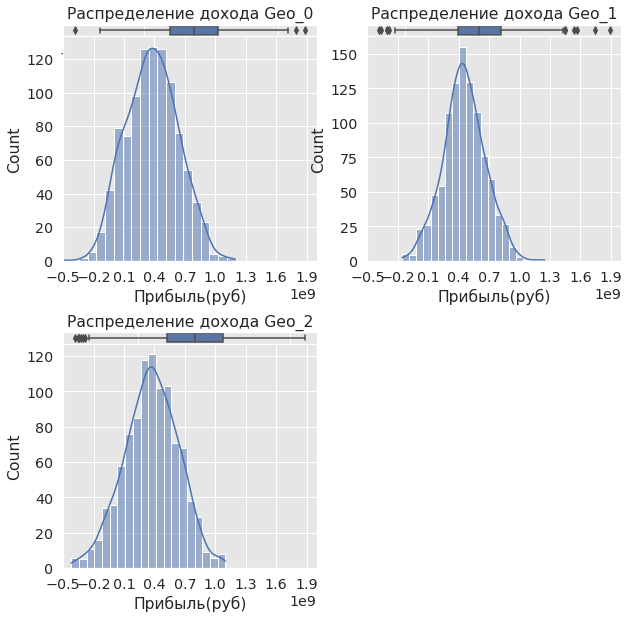

In [75]:
multi_subplot([geo_0_revenue, geo_1_revenue, geo_2_revenue],
              xrange=(-0.5e9, 2e9, 0.3e9),
              bins=20,
              font_scale=1.3,
              figsize=(10, 10),
              title=["Распределение дохода Geo_0",
                     "Распределение дохода Geo_1",
                     "Распределение дохода Geo_2",],
              xlabel=["Прибыль(руб)"]*3)

вывод: по гистограмме распределений прибыли у регионов Geo_0 и Geo_2 наблюдается левый хвост с 
       отрицательной прибылью;
       
       сравнивая гистограммы по частоте, у региона Geo_1 она немного выше (надежнее) в зоне 
       мат. ожидания, а средняя прибыль выше,поэтому лучший регион - Geo_1 с средней прибылью 
       455 007 924 руб. и  с вероятностью получения убытков 1.4%,что меньше  2.5%(согласно ТЗ) 
       Выбираю его для разработки месторождения.

# ОБЩИЙ ВЫВОД

В результате данной работы были проведены исследования и сделаны выводы:

1. Загрузил и подготовил данные для исследования:

   Пропуски и дубликаты в данных отсутствуют;

   Все признаки имеют числовое представление;

   Столбцы с признаком id удалены из всех регионов;

   Объем запасов нефти распределен между регионами неравномерно;
   

2. Данные  разбил на обучающую и валидационную выборки в пропорции 75:25; 

   Модели LinearRegression обучены на каждом регионе, предсказания сделаны; 
   
   Ошибка модели LinearRegression по метрике RMSE не отлчается на обучающей и валидационной выборке;

   
3. Рассчитал необходимое количество сырья для безубыточной разработки новой скважины: 111.11 баррелей;

   После сравнения средних предсказанных моделью запасов сырья, выяснил, что среднее значение 
   запасов во всех трех регионах меньше необходимого количества для безубыточной разработки;
   
   
4. Проведел селекцию скважин и отобрал  в каждом регионе процедурой Bootstrap лучшие, 
   по которым расчитал распределение прибыли в регионе;
   
   Оценил доверительные интервалы полученых распределений прибыли в регионах.
   
   
   
5.  Данные были визулизированы гистограммой и диаграммой распределения в каждом регионе. 
    
    По гистограмме распределений прибыли у регионов Geo_0 и Geo_2 наблюдается левый хвост 
    с  отрицательной прибылью;
       
    Лучший регион для разработки месторождения - Geo_1 со средней прибылью 455 007 924 руб. 
    и  с вероятностью получения убытков 1.4%, что меньше  2.5% (согласно ТЗ).
    Выбираю его для разработки месторождения.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ x]  Весь код выполняется без ошибок
- [x ]  Ячейки с кодом расположены в порядке исполнения
- [ x]  Выполнен шаг 1: данные подготовлены
- [ x]  Выполнен шаг 2: модели обучены и проверены
    - [x ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x ]  Модели обучены, предсказания сделаны
    - [x ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ x]  На экране напечатаны результаты
    - [ x]  Сделаны выводы
- [x ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ x]  Для всех ключевых значений созданы константы Python
    - [ x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x ]  По предыдущему пункту сделаны выводы
    - [ x]  Написана функция расчёта прибыли
- [x ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ x]  Проведена процедура *Bootstrap*
    - [ x]  Все параметры бутстрепа соответствуют условию
    - [ x]  Найдены все нужные величины
    - [ x]  Предложен регион для разработки месторождения
    - [ x]  Выбор региона обоснован